In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import sys, os
sys.path.insert(0, os.path.abspath('../utils'))
from MastodonFunctions import xml_features, csv_features, ordering_tracks, smoothing_filter, peak_detection, bulk_peak_analysis

# Figure 4 - In vivo data analysis

In [2]:
# Position 1 and 2 correspond to two embryos from the same experiment
position = [1,2]

In [3]:
# Path to .xml file generated when creating the .hdf5
path_xml = ['../Data/Figure 4/Figure 4 - In vivo/Position1_20191213.xml', '../Data/Figure 4/Figure 4 - In vivo/Position2_20191213.xml']

# Path to the -edges.csv amd -vertices.csv files (You only need path + name of file without the -edges or -vertices extension)
path_csv = ['../Data/Figure 4/Figure 4 - In vivo/Position1', '../Data/Figure 4/Figure 4 - In vivo/Position2']

### Image characteristics

In [4]:
# Time resolution in seconds (how often do you acquire time points)
tr = 90
tr_min = round(tr/60,2) # in minutes

for i in range(len(position)):
    exec('fts%d = xml_features(path_xml[i])'%position[i])
    
    fts = xml_features(path_xml[i])
    
    # Features from the image obtained from the .xml generated by BigData Viewer
    print('Image features from POSITION # %d'%(i+1))
    print('The image has the following dimensions (XYZC): %d, %d, %d, %d'%(fts.width, fts.height, fts.n_slices, fts.channels))
    print('There are %d frames in total.'%fts.n_frames)
    print('Pixel Size: x = %.3g %s, y = %.3g %s z = %.2g %s'%(fts.x_pixel, fts.units, fts.y_pixel, fts.units, fts.z_pixel, fts.units))
    print('There are %d Z-slices in total'%fts.n_slices)
    print(' ')

Image features from POSITION # 1
The image has the following dimensions (XYZC): 2048, 2048, 150, 2
There are 299 frames in total.
Pixel Size: x = 0.347 micron, y = 0.347 micron z = 1.5 micron
There are 150 Z-slices in total
 
Image features from POSITION # 2
The image has the following dimensions (XYZC): 2048, 2048, 150, 2
There are 299 frames in total.
Pixel Size: x = 0.347 micron, y = 0.347 micron z = 1.5 micron
There are 150 Z-slices in total
 


### Organize the data

In [5]:
# Save tracks coming from all experiments

for i in range(len(position)):
    # Function to obtain all the spots' information from the .csv file
    spots = csv_features(path_csv[i], path_xml[i])
    
    # Order the time series according to each individual cell
    exec('tracks%d = ordering_tracks(path_csv[i], path_xml[i])'%position[i])

### Peak alignment

In [6]:
# Align using their temporal position

# First find the experiment with the maximum number of frames
# Then compute the number of total cells in all experiments

n_cells_pos = []
n_frames = 0

for i in range(len(position)):
    n_cells_pos.append(eval('tracks%d.n_tracks_divs'%position[i]))
    if eval('fts%d.n_frames'%position[i])>n_frames:
        n_frames = eval('fts%d.n_frames'%position[i])

n_cells = sum(n_cells_pos)    

# Save all the cells from all the experiments in the same array 
tracks_save = np.ones((n_cells, n_frames))*np.nan

count = 0

for k in range(len(position)):
    # Fill the timepoints where there are no cells tracked with nan
    tracks_aux = np.ones((n_cells_pos[k], n_frames))*np.nan

    # For each track 
    for i in range(n_cells_pos[k]):

        # Add the tracked spot to the specific time frame to which it corresponds
        for j,val in enumerate(eval('tracks%d.spots_features["Frames"][i]'%position[k])):
            tracks_aux[i,val] = eval('tracks%d.spots_features["Mean1"][i][j]'%position[k])
            
    tracks_save[count:count+n_cells_pos[k],:] = tracks_aux
    
    count += n_cells_pos[k]

### Peak deteciton 

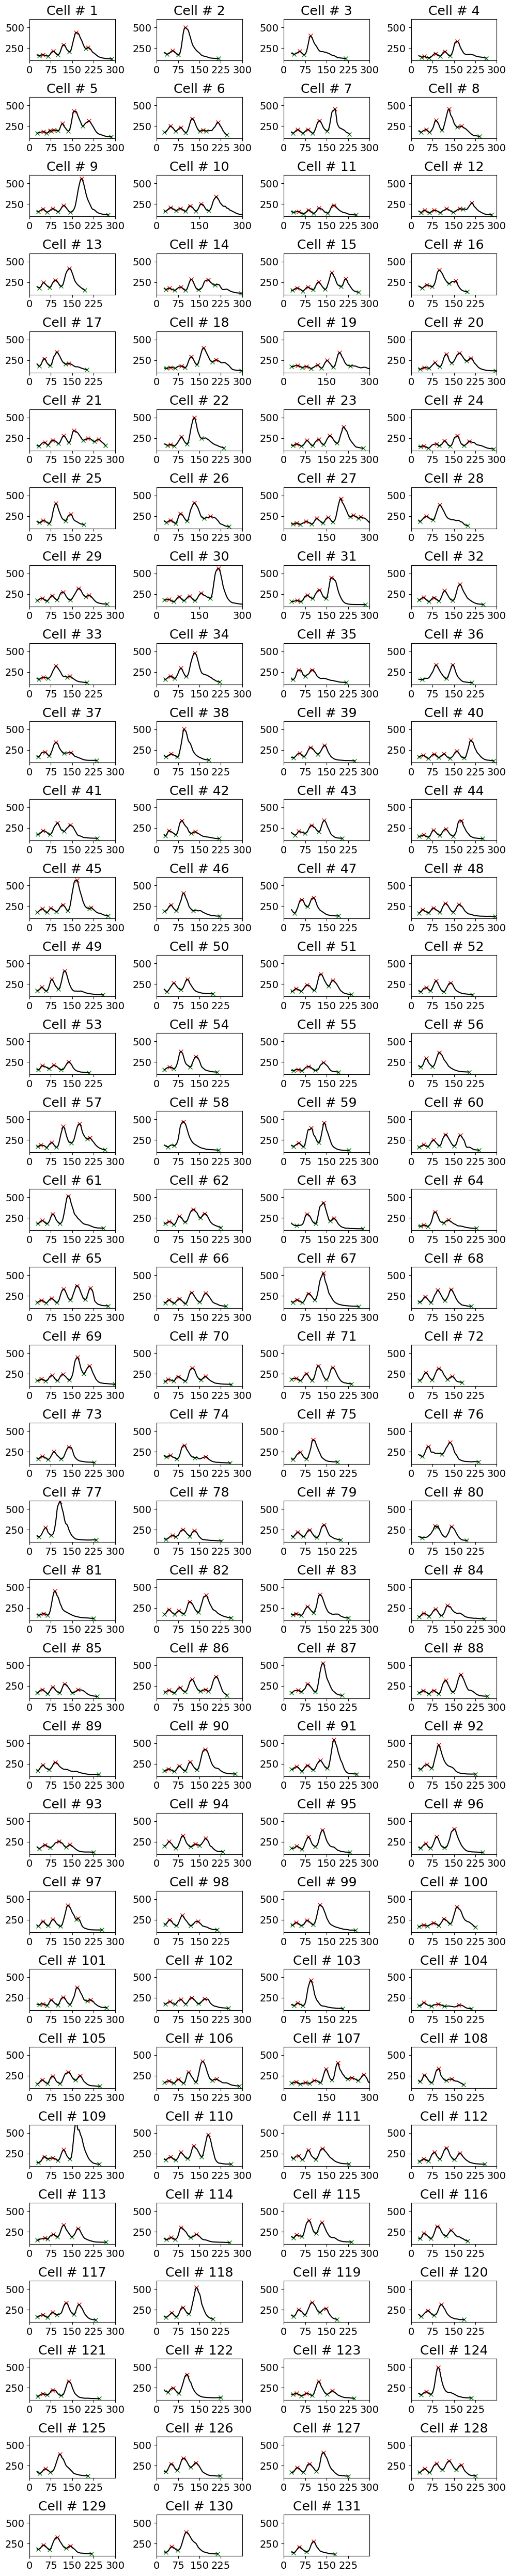

In [7]:
# Peak detection parameters
ind = 0 #8 
# Threshold
th_val = 0 # For maxima
th_val_ = 0 # For minima

# Prominence
prominence_val = 8.1 # For maxima
prominence_val_ = 2 # For minima

# Width
width_val = 2 # For maxima
width_val_ = 2 # For minima

# Distance
dist_val = 1 # For maxima
dist_val_ = 1 # For minima

# Averaging window size
window = 9

# If you want ts and as analysis: 'ts_as', ow no_ts_as
analysis = 'ts_as'

# Define the dimensions of the subplot
n_cols =  4
n_rows = np.ceil((n_cells + 1) / n_cols)
plot_num = 1

# Initialize the figure size
ax = plt.figure(figsize=[10,50])

max_peaks_all = []
min_peaks_all = []
max_val_all = []
min_val_all = []
periods_all = []

times_max_val_all = []

# To obtain the maximum number of cycles
max_n_cycles = 0

for j in range(n_cells):
    
    # Update the number of subplots    
    ax = plt.subplot(int(n_rows), n_cols, plot_num, aspect='auto')
    plot_num += 1
    
    peaks = peak_detection(tracks_save[j][ind:], window, th_val, th_val_, \
                           dist_val, dist_val_, prominence_val,prominence_val_, width_val, width_val_, analysis)
    
    # If no peaks are detected, print the cell number
    if peaks.count > 0 :
        print(j+1)

    # Correct for the last peak in case it was not detected:
    y = smoothing_filter(tracks_save[j][ind:], window)
    
    # Add a minimum in the last position of the trace (first position after the last maximum which is not a nan)
    peaks.peaks_[-1] =  np.where(np.isnan(y))[0][np.where(np.where(np.isnan(y))[0]>peaks.peaks[-1])[0][0]]-1
    
    # Add a minimum in the first position of the trace (first position after the last maximum which is not a nan) in case there is no minima
    if np.isnan(y[peaks.peaks_][0]):
        peaks.peaks_[0] =  np.where(np.where(np.isnan(y))[0]<peaks.peaks[0])[0][-1]+1
    
    # Save peaks (in time)
    max_peaks_all.append((peaks.peaks+window/2)*tr_min)
    min_peaks_all.append((peaks.peaks_+window/2)*tr_min)
    
    # Save maxima intensity
    max_val_all.append(y[peaks.peaks])
    times_max_val_all.append(peaks.peaks*tr_min)
    
    # Save minima
    min_val_all.append(y[peaks.peaks_][:-1])
    
    # Save periods
    if len(peaks.peaks)>1:
        periods_all.append(np.diff(peaks.peaks)*tr_min)
    
    if len(peaks.peaks)>max_n_cycles:
        max_n_cycles = len(peaks.peaks)
        
    plt.plot(peaks.peaks, y[peaks.peaks], "xr"); plt.plot(peaks.peaks_, y[peaks.peaks_], "xg"); plt.plot(y, color='k'); #plt.legend(['Max Peak', 'Min Peak'])
    plt.title('Cell # %d'%(j+1), fontsize = 18)
    locs, labels = plt.xticks()
    plt.xticks(locs, map(int,np.round(locs*tr_min)), fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim([0,200])
    plt.ylim([100,600])


plt.tight_layout()
plt.show()

## Minimum vs Maximum amplitude values

In [8]:
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

In [9]:
min_val_cycle = {new_list: [] for new_list in range(1,max_n_cycles+1,)}
max_val_cycle = {new_list: [] for new_list in range(1,max_n_cycles+1,)}

for i in range(len(min_val_all)):
    # If we have the same number of maxima and minima, then we can compare
    if len(min_val_all[i]) == len(max_val_all[i]):
        # Save the value of each maxima/minim according to the cycle
        for j in range(len(min_val_all[i])):
            min_val_cycle[j+1].append(min_val_all[i][j])
            max_val_cycle[j+1].append(max_val_all[i][j])
            
# Convert into list arrays  
min_cycle = []
max_cycle = []

for i in range(max_n_cycles):
    min_cycle.append(np.array(min_val_cycle[i+1]))
    max_cycle.append(np.array(max_val_cycle[i+1]))     

In [10]:
print('Cycle 1: %d cells'%len(min_val_cycle[1]))
print('Cycle 2: %d cells'%len(min_val_cycle[2]))
print('Cycle 3: %d cells'%len(min_val_cycle[3]))
print('Cycle 4: %d cells'%len(min_val_cycle[4]))
print('Cycle 5: %d cells'%len(min_val_cycle[5]))

Cycle 1: 126 cells
Cycle 2: 126 cells
Cycle 3: 103 cells
Cycle 4: 56 cells
Cycle 5: 23 cells


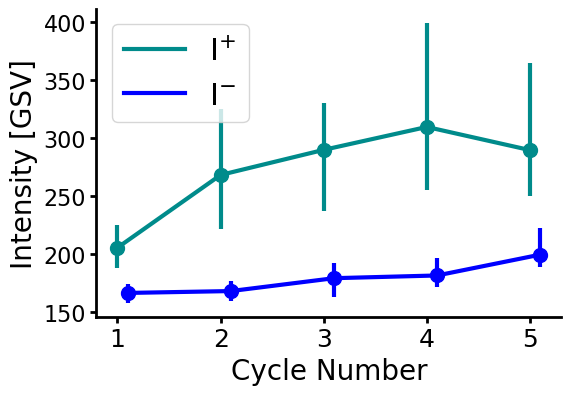

In [11]:
# Plot

fig = plt.figure(figsize=[6,4])


# Maxima
max_nan = []
quartile1 = []
quartile3 = []
medians = []

for i in range(max_n_cycles-2):
    aux = max_cycle[i][~np.isnan(max_cycle[i])]
    max_nan.append(aux)
    quartile1.append(np.percentile(aux, [25, 50, 75])[0])
    medians.append(np.percentile(aux, [25, 50, 75])[1])
    quartile3.append(np.percentile(aux, [25, 50, 75])[2])


# Add medians
whiskers = np.array([adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(max_nan, quartile1, quartile3)])
whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]

# Plot ticks 
plt.xticks(np.arange(0,max_n_cycles-2,1), np.arange(1,max_n_cycles-1,1), fontsize=16);
plt.yticks(fontsize=16)
plt.xlabel('Number of cycles', fontsize=18)
plt.ylabel('Amplitude [a.u.]', fontsize=18)
#plt.ylim([0,40])

inds = np.arange(0, len(medians) )
plt.plot(inds,medians, color='darkcyan', linewidth=3, label=r'I$^{+}$')
plt.scatter(inds, medians, marker='o', color='darkcyan', s=100, zorder=3)
plt.vlines(inds, quartile1, quartile3, color='darkcyan', linestyle='-', lw=3)
#plt.vlines(inds, whiskersMin, whiskersMax, color='blue', linestyle='-', lw=3)


# Minima

# Remove nans for violin plot
min_nan = []
quartile1 = []
quartile3 = []
medians = []

for i in range(max_n_cycles-2):
    aux = min_cycle[i][~np.isnan(min_cycle[i])]
    min_nan.append(aux)
    quartile1.append(np.percentile(aux, [25, 50, 75])[0])
    medians.append(np.percentile(aux, [25, 50, 75])[1])
    quartile3.append(np.percentile(aux, [25, 50, 75])[2])


# Add medians
whiskers = np.array([adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(min_nan, quartile1, quartile3)])
whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(0, len(medians) )+0.1
plt.plot(inds, medians, color='blue', linewidth=3, label=r'I$^{-}$')
plt.scatter(inds, medians, marker='o', color='blue', s=100, zorder=3)
plt.vlines(inds, quartile1, quartile3, color='blue', linestyle='-', lw=3)
#plt.vlines(inds, whiskersMin, whiskersMax, color='black', linestyle='-', lw=3)


plt.xticks(np.arange(0,max_n_cycles-2,1), np.arange(1,max_n_cycles-1,1), fontsize=18);
plt.yticks(fontsize=16)
plt.xlabel('Cycle Number', fontsize=20)
plt.ylabel('Intensity [GSV]', fontsize=20)
plt.legend(loc='upper left', fontsize=22)

ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)
    
plt.show()

fig.savefig('../Data/Figure 4/Figure 4 - In vivo/Results/MaxMinAmplitude-Bycycle.pdf', format='pdf', bbox_inches='tight')

## Periods by cycle

In [12]:
period_val_cycle = {new_list: [] for new_list in range(1,max_n_cycles+1,)}

for i in range(len(periods_all)):

    # Save the value of each period according to the cycle
    for j in range(len(periods_all[i])):
        period_val_cycle[j+1].append(periods_all[i][j])

# Convert into list arrays  
period_cycle = []

for i in range(max_n_cycles):
    period_cycle.append(np.array(period_val_cycle[i+1]))
       

In [13]:
print('Cycle 1: %d cells'%len(period_val_cycle[1]))
print('Cycle 2: %d cells'%len(period_val_cycle[2]))
print('Cycle 3: %d cells'%len(period_val_cycle[3]))
print('Cycle 4: %d cells'%len(period_val_cycle[4]))
print('Cycle 5: %d cells'%len(period_val_cycle[5]))

Cycle 1: 130 cells
Cycle 2: 106 cells
Cycle 3: 58 cells
Cycle 4: 24 cells
Cycle 5: 4 cells


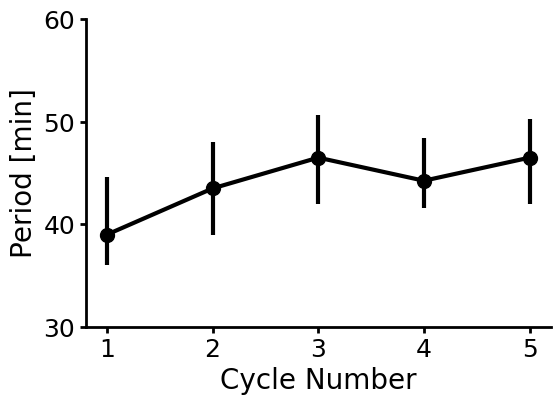

In [14]:
# Plot
fig = plt.figure(figsize=[6,4])

# Maxima
period_nan = []
quartile1 = []
quartile3 = []
medians = []

for i in range(max_n_cycles-2):
    aux = period_cycle[i][~np.isnan(period_cycle[i])]
    period_nan.append(aux)
    quartile1.append(np.percentile(aux, [25, 50, 75])[0])
    medians.append(np.percentile(aux, [25, 50, 75])[1])
    quartile3.append(np.percentile(aux, [25, 50, 75])[2])


# Add medians
whiskers = np.array([adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(period_nan, quartile1, quartile3)])
whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]


inds = np.arange(0, len(medians) )
plt.plot(inds,medians, color='black', linewidth=3, label='Max Amp')
plt.scatter(inds, medians, marker='o', color='black', s=100, zorder=3)
plt.vlines(inds, quartile1, quartile3, color='black', linestyle='-', lw=3)
#plt.vlines(inds, whiskersMin, whiskersMax, color='red', linestyle='-', lw=3)



plt.xticks(np.arange(0,max_n_cycles-2,1), np.arange(1,max_n_cycles-1,1), fontsize=18);
#plt.xticks(np.arange(0,max_n_cycles-3,1), np.arange(2,max_n_cycles-1,1), fontsize=18);
plt.yticks(np.arange(30,65,10), fontsize=18)
plt.ylim([30,60])
plt.xlabel('Cycle Number', fontsize=20)
plt.ylabel('Period [min]', fontsize=20)

ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.show()

fig.savefig('../Data/Figure 4/Figure 4 - In vivo/Results/Periods-Bycycle.pdf', format='pdf', bbox_inches='tight')

### Ts and As calculation

In [15]:
T_minus = []
T_plus = []
A_minus = []
A_plus = []
n_cycles = []
pos_last_Tplus = []

for j in range(n_cells):
    peaks = peak_detection(tracks_save[j][ind:], window, th_val, th_val_, \
                           dist_val, dist_val_, prominence_val,prominence_val_, width_val, width_val_, analysis)
    
    # If no peaks are detected, print the cell number
    if peaks.count > 0 :
        print(j+1)

    # Correct for the last peak in case it was not detected:
    y = smoothing_filter(tracks_save[j][ind:], window)
    
    # Add a minimum in the last position of the trace (first position after the last maximum which is not a nan)
    peaks.peaks_[-1] =  np.where(np.isnan(y))[0][np.where(np.where(np.isnan(y))[0]>peaks.peaks[-1])[0][0]]-1
    
    # Add a minimum in the first position of the trace (first position after the last maximum which is not a nan) in case there is no minima
    if np.isnan(y[peaks.peaks_][0]):
        peaks.peaks_[0] =  np.where(np.where(np.isnan(y))[0]<peaks.peaks[0])[0][-1]+1

    T_minus.append(peaks.cycles_T_minus_plot)
    T_plus.append(peaks.cycles_T_plus_plot)
    A_minus.append(peaks.cycles_A_minus_plot)
    A_plus.append(peaks.cycles_A_plus_plot)
    n_cycles.append(peaks.n_cycles)
        

bulk_peaks = bulk_peak_analysis(T_minus, T_plus, A_minus, A_plus)

## Ts and As by cycle

In [16]:
# Arange by cycles

T_plus_by_cycle = {new_list: [] for new_list in range(1,max(n_cycles)+1,)} 
T_minus_by_cycle = {new_list: [] for new_list in range(1,max(n_cycles)+1,)}
A_plus_by_cycle = {new_list: [] for new_list in range(1,max(n_cycles)+1,)}
A_minus_by_cycle = {new_list: [] for new_list in range(1,max(n_cycles)+1,)}

# Plot the data
for j,val in enumerate(n_cycles):
    # Convert "cycles minus/plus plot" into a list in order to plot it
    lists1 = T_minus[j][:-1]
    lists2 = A_minus[j][:-1]
    lists3 = T_plus[j][1:]
    lists4 = A_plus[j][1:]
    
    for i in range(val-1):
        T_plus_by_cycle[i+1].append(lists3[i][0])
        T_minus_by_cycle[i+1].append(lists1[i][0])
        A_plus_by_cycle[i+1].append(lists4[i][0])
        A_minus_by_cycle[i+1].append(lists2[i][0])
        
# Convert into list arrays  
A_plus_cycle = []
A_minus_cycle = []
T_plus_cycle = []
T_minus_cycle = []

for i in range(max(n_cycles)):
    A_plus_cycle.append(np.array(A_plus_by_cycle[i+1]))
    A_minus_cycle.append(np.array(A_minus_by_cycle[i+1]))
    T_plus_cycle.append(np.array(T_plus_by_cycle[i+1]))
    T_minus_cycle.append(np.array(T_minus_by_cycle[i+1]))

In [17]:
print('Cycle 1: %d cells'%len(period_val_cycle[1]))
print('Cycle 2: %d cells'%len(period_val_cycle[2]))
print('Cycle 3: %d cells'%len(period_val_cycle[3]))
print('Cycle 4: %d cells'%len(period_val_cycle[4]))
print('Cycle 5: %d cells'%len(period_val_cycle[5]))

Cycle 1: 130 cells
Cycle 2: 106 cells
Cycle 3: 58 cells
Cycle 4: 24 cells
Cycle 5: 4 cells


### Ts by cycle

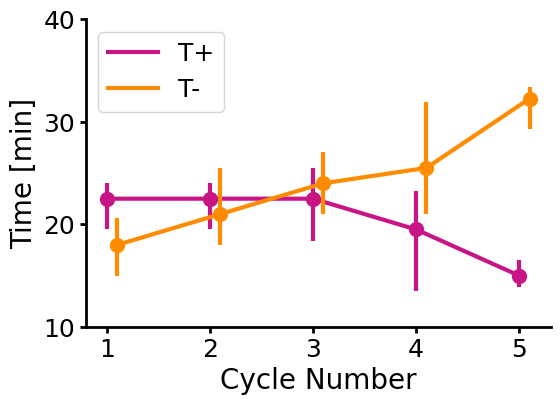

In [18]:
fig = plt.figure(figsize=[6,4])

#  T +
# Remove nans for violin plot
T_plus_nan = []
quartile1 = []
quartile3 = []
medians = []

n_cycles_all = max(n_cycles)-1
for i in range(n_cycles_all-1):
    aux = T_plus_cycle[i][~np.isnan(T_plus_cycle[i])]*tr_min
    T_plus_nan.append(aux)
    quartile1.append(np.percentile(aux, [25, 50, 75])[0])
    medians.append(np.percentile(aux, [25, 50, 75])[1])
    quartile3.append(np.percentile(aux, [25, 50, 75])[2])

medians_plus = medians

# Add medians
whiskers = np.array([adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(T_plus_nan, quartile1, quartile3)])
whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]

# Plot ticks 
plt.xticks(np.arange(0,n_cycles_all-1,1), np.arange(1,n_cycles_all,1), fontsize=16);
plt.yticks(fontsize=16)
plt.xlabel('Number of cycles', fontsize=18)
plt.ylabel('T+ [min]', fontsize=18)
plt.ylim([0,40])

inds = np.arange(0, len(medians) )
plt.plot(inds,medians, color='mediumvioletred', linewidth=3, label='T+')
plt.scatter(inds, medians, marker='o', color='mediumvioletred', s=100, zorder=3)
plt.vlines(inds, quartile1, quartile3, color='mediumvioletred', linestyle='-', lw=3)
#plt.vlines(inds, whiskersMin, whiskersMax, color='blue', linestyle='-', lw=2)


# T -

# Remove nans for violin plot
T_minus_nan = []
quartile1 = []
quartile3 = []
medians = []

for i in range(n_cycles_all-1):
    aux = T_minus_cycle[i][~np.isnan(T_minus_cycle[i])]*tr_min
    T_minus_nan.append(aux)
    quartile1.append(np.percentile(aux, [25, 50, 75])[0])
    medians.append(np.percentile(aux, [25, 50, 75])[1])
    quartile3.append(np.percentile(aux, [25, 50, 75])[2])

medians_minus = medians

# Add medians
whiskers = np.array([adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(T_minus_nan, quartile1, quartile3)])
whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(0, len(medians) )+0.1
plt.plot(inds, medians, color='darkorange', linewidth=3, label='T-')
plt.scatter(inds, medians, marker='o', color='darkorange', s=100, zorder=3)
plt.vlines(inds, quartile1, quartile3, color='darkorange', linestyle='-', lw=3)
#plt.vlines(inds, whiskersMin, whiskersMax, color='black', linestyle='-', lw=2)

# Plot ticks 
plt.xticks(np.arange(0,n_cycles_all-1,1), np.arange(1,n_cycles_all,1), fontsize=18);
plt.yticks(np.arange(10,50,10), fontsize=18)
plt.xlabel('Cycle Number', fontsize=20)
plt.ylabel('Time [min]', fontsize=20)
plt.ylim([10,40])
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)
plt.legend(loc='best', fontsize=18)

plt.show()

fig.savefig('../Data/Figure 4/Figure 4 - In vivo/Results/Ts-Bycycle.pdf', format='pdf', bbox_inches='tight')

### Ts by cycle - percentage of period

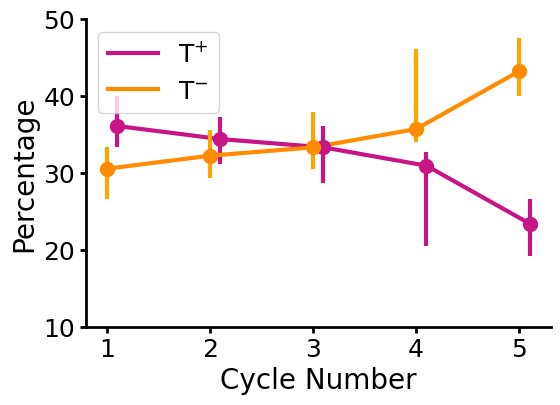

In [19]:
fig = plt.figure(figsize=[6,4])
percentage_T_plus = []
percentage_T_minus = []

quartile1_T_plus = []
quartile1_T_minus = []
quartile3_T_plus = []
quartile3_T_minus = []
medians_T_plus = []
medians_T_minus = []

for i in range(n_cycles_all-1):
    aux1 = np.array(T_plus_cycle[i][~np.isnan(T_plus_cycle[i])]*tr_min)
    aux2 = np.array(period_cycle[i]*tr_min)
    percentage_T_plus.append((aux1/aux2)*100)
    
    quartile1_T_plus.append(np.percentile(np.array((aux1/aux2)*100), [25, 50, 75])[0])
    medians_T_plus.append(np.percentile(np.array((aux1/aux2)*100), [25, 50, 75])[1])
    quartile3_T_plus.append(np.percentile(np.array((aux1/aux2)*100), [25, 50, 75])[2])
    
    aux1 = np.array(T_minus_cycle[i][~np.isnan(T_minus_cycle[i])]*tr_min)
    aux2 = np.array(period_cycle[i]*tr_min)
    
    percentage_T_minus.append(aux1/aux2)
    quartile1_T_minus.append(np.percentile(np.array((aux1/aux2)*100), [25, 50, 75])[0])
    medians_T_minus.append(np.percentile(np.array((aux1/aux2)*100), [25, 50, 75])[1])
    quartile3_T_minus.append(np.percentile(np.array((aux1/aux2)*100), [25, 50, 75])[2])
    
# Plot the results

# Add medians
whiskers = np.array([adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(percentage_T_minus, quartile1_T_minus, quartile3_T_minus)])
whiskersMin_m, whiskersMax_m = whiskers[:, 0], whiskers[:, 1]

whiskers = np.array([adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(percentage_T_plus, quartile1_T_plus, quartile3_T_plus)])
whiskersMin_p, whiskersMax_p = whiskers[:, 0], whiskers[:, 1]

inds_m = np.arange(0, len(medians_T_minus) )
inds_p = np.arange(0, len(medians_T_plus) )+0.1

# Plus
plt.plot(inds_p, medians_T_plus, color='mediumvioletred', linewidth=3, label=r'T$^{+}$')
plt.scatter(inds_p, medians_T_plus, marker='o', color='mediumvioletred', s=100, zorder=3)
plt.vlines(inds_p, quartile1_T_plus, quartile3_T_plus, color='mediumvioletred', linestyle='-', lw=3)
#plt.vlines(inds_p, whiskersMin_p, whiskersMax_p, color='blue', linestyle='-', lw=2)

# Minus
plt.plot(inds_m, medians_T_minus, color='darkorange', linewidth=3, label=r'T$^{-}$')
plt.scatter(inds_m, medians_T_minus, marker='o', color='darkorange', s=100, zorder=3)
plt.vlines(inds_m, quartile1_T_minus, quartile3_T_minus, color='orange', linestyle='-', lw=3)
#plt.vlines(inds_m, whiskersMin_m, whiskersMax_m, color='black', linestyle='-', lw=2)


# Plot ticks 
plt.xticks(np.arange(0,n_cycles_all-1,1), np.arange(1,n_cycles_all,1), fontsize=18);
plt.yticks(np.arange(10,60,10), fontsize=18)
plt.xlabel('Cycle Number', fontsize=20)
plt.ylabel('Percentage', fontsize=20)
plt.legend(loc='upper left', fontsize=18)
plt.ylim([10,50])

ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.show()
fig.savefig('../Data/Figure 4/Figure 4 - In vivo/Results/Ts_Percentage-Bycycle.pdf', format='pdf', bbox_inches='tight')

### Ts and Period plot 

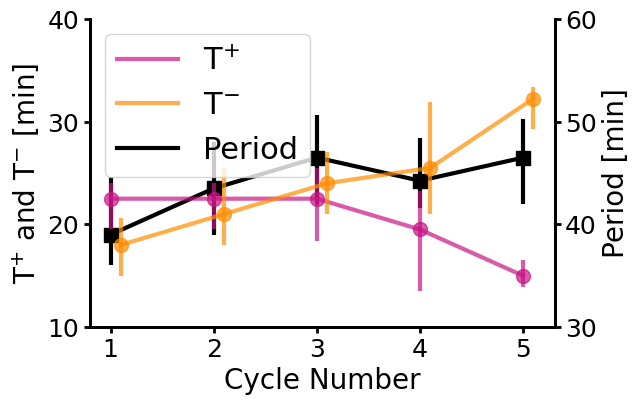

In [20]:
fig,ax = plt.subplots(figsize=[6,4])

#  T +
# Remove nans for violin plot
T_plus_nan = []
quartile1 = []
quartile3 = []
medians = []

n_cycles_all = max(n_cycles)-1
for i in range(n_cycles_all-1):
    aux = T_plus_cycle[i][~np.isnan(T_plus_cycle[i])]*tr_min
    T_plus_nan.append(aux)
    quartile1.append(np.percentile(aux, [25, 50, 75])[0])
    medians.append(np.percentile(aux, [25, 50, 75])[1])
    quartile3.append(np.percentile(aux, [25, 50, 75])[2])

medians_plus = medians

# Add medians
whiskers = np.array([adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(T_plus_nan, quartile1, quartile3)])
whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(0, len(medians) )
sc1 = plt.plot(inds,medians, color='mediumvioletred', linewidth=3, label='T$^{+}$',alpha=0.7)
plt.scatter(inds, medians, marker='o', color='mediumvioletred', s=100, zorder=3,alpha=0.7)
plt.vlines(inds, quartile1, quartile3, color='mediumvioletred', linestyle='-', lw=3,alpha=0.7)
#plt.vlines(inds, whiskersMin, whiskersMax, color='blue', linestyle='-', lw=2)


# T -

# Remove nans for violin plot
T_minus_nan = []
quartile1 = []
quartile3 = []
medians = []

for i in range(n_cycles_all-1):
    aux = T_minus_cycle[i][~np.isnan(T_minus_cycle[i])]*tr_min
    T_minus_nan.append(aux)
    quartile1.append(np.percentile(aux, [25, 50, 75])[0])
    medians.append(np.percentile(aux, [25, 50, 75])[1])
    quartile3.append(np.percentile(aux, [25, 50, 75])[2])

medians_minus = medians

# Add medians
whiskers = np.array([adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(T_minus_nan, quartile1, quartile3)])
whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(0, len(medians) )+0.1
sc2 = ax.plot(inds, medians, color='darkorange', linewidth=3, label='T$^{-}$',alpha=0.7)
ax.scatter(inds, medians, marker='o', color='darkorange', s=100, zorder=3,alpha=0.7)
ax.vlines(inds, quartile1, quartile3, color='darkorange', linestyle='-', lw=3,alpha=0.7)
#plt.vlines(inds, whiskersMin, whiskersMax, color='black', linestyle='-', lw=2)

# PERIOD PLOT --------------------------------

ax2=ax.twinx()

# Maxima
period_nan = []
quartile1 = []
quartile3 = []
medians = []

for i in range(max_n_cycles-2):
    aux = period_cycle[i][~np.isnan(period_cycle[i])]
    period_nan.append(aux)
    quartile1.append(np.percentile(aux, [25, 50, 75])[0])
    medians.append(np.percentile(aux, [25, 50, 75])[1])
    quartile3.append(np.percentile(aux, [25, 50, 75])[2])


# Add medians
whiskers = np.array([adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(period_nan, quartile1, quartile3)])
whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]


inds = np.arange(0, len(medians) )
sc3 = ax2.plot(inds,medians, color='black', linewidth=3, zorder=1,label='Period')
ax2.scatter(inds, medians, marker='s', color='black', s=100, zorder=1)
ax2.vlines(inds, quartile1, quartile3, color='black', linestyle='-', lw=3, zorder=1)
#plt.vlines(inds, whiskersMin, whiskersMax, color='red', linestyle='-', lw=3)

ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)

# PLOT TICKS ----------------------------------

ax.set_xticks(np.arange(0,n_cycles_all-1,1));
ax.set_xticklabels(np.arange(1,n_cycles_all,1), fontsize=18)

ax.set_yticks(np.arange(10,50,10))
ax.set_yticklabels(np.arange(10,50,10), fontsize=18)

ax.set_xlabel('Cycle Number', fontsize=20)
ax.set_ylabel('T$^{+}$ and T$^{-}$ [min]', fontsize=20)
ax.set_ylim([10,40])
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)

# Merge the legends
lns = sc1+sc2+sc3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0, fontsize=22)


ax2.set_yticks(np.arange(30,65,10))
ax2.set_yticklabels(np.arange(30,65,10), fontsize=18)
ax2.set_ylim([30,60])

ax2.set_ylabel('Period [min]', fontsize=20)

ax2.tick_params(width=2, length=4)
ax2.spines['top'].set_linewidth(0)
ax2.spines['bottom'].set_linewidth(2)
ax2.spines['left'].set_linewidth(2)
ax2.spines['right'].set_linewidth(2)

plt.show()

fig.savefig('../Data/Figure 4/Figure 4 - In vivo/Results/Ts-Period-Bycycle.pdf', format='pdf', bbox_inches='tight')